## 필요한 라이브러리 불러오기

In [1]:
import os
import numpy as np
import random

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(1)

# 1. 회귀문제

## 데이터 불러오기

In [3]:
bicycle = pd.read_csv("./data/regression.csv")

#### 1. null값 10개 미만 : 최빈값으로 대체 (동일한 개수의 최빈값이 있으면 더 작은 값 선택)


In [4]:
bicycle.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

In [5]:
for i in bicycle:
    if bicycle[i].isnull().sum() <10:
        newb = bicycle[i].fillna(bicycle[i].mode()[0], inplace=True)
        # inplace=True : 원본 데이터 변경

#### 2. null값 10개 이상 100개 미만 : 평균값으로 대체


In [6]:
for i in bicycle:
    if bicycle[i].isnull().sum() <100 and bicycle[i].isnull().sum()>=10:
        bicycle[i].fillna(bicycle[i].mean(), inplace=True)

#### 3. null값 100개 이상 : null값 행 제거 


In [7]:
for i in bicycle:
    if bicycle[i].isnull().sum() >=100:
        bicycle.dropna(axis=0, how='any', inplace=True)

In [8]:
bicycle[:20]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
5,13,2,13.6,0.0,1.7,80.0,1073.0,0.027,34.0,15.0,39.0
6,14,3,10.6,0.0,1.5,58.0,1548.0,0.038,62.0,33.0,23.0
7,16,21,16.0,0.0,6.0,21.0,1961.0,0.050,90.0,28.0,146.0
8,19,9,13.8,0.0,1.9,64.0,1344.0,0.039,93.0,19.0,39.0
9,20,14,17.2,0.0,2.1,32.0,1571.0,0.025,64.0,19.0,83.0


#### 4. id 변수 제거


In [9]:
bicycle.drop(labels="id", axis=1, inplace=True)

#### 5. 전처리 후 index를 0부터 차례로 재정렬 진행


In [10]:
bicycle.reset_index(drop=True, inplace=True)

#### 6. count를 y값, 나머지를 X값으로 처리

In [11]:
x = bicycle.drop(['count'], axis=1)

In [12]:
y = bicycle['count']


#### 7. X와 y의 통계량 출력(describe 함수 사용)

In [13]:
x.describe()

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
count,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000
mean,11.918778,16.894262,0.029806,2.494188,51.627422,1417.240686,0.039152,57.351094,30.327124
std,6.744852,5.195518,0.170116,1.379474,20.144847,576.653123,0.019358,31.109769,14.713252
min,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000
25%,6.000000,13.100000,0.000000,1.400000,36.000000,904.500000,0.026000,36.000000,20.000000
50%,12.000000,16.800000,0.000000,2.400000,50.000000,1587.000000,0.039000,52.000000,26.000000
75%,18.000000,20.300000,0.000000,3.400000,67.000000,1994.000000,0.052000,70.000000,37.000000
max,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000


In [14]:
y.describe()

count    1342.000000
mean      111.166915
std        83.021073
min         1.000000
25%        37.000000
50%       101.000000
75%       154.000000
max       431.000000
Name: count, dtype: float64

## 1-2) 다중공선성 확인

#### 1 heatmap을 그리고 이를 통해 상관관계가 제일 큰 두개의 변수 중 종속변수(y)와 상관관계가 더 낮은 변수 제거
* 이때 하나의 변수가 제거된 X를 X2로 새로 지정

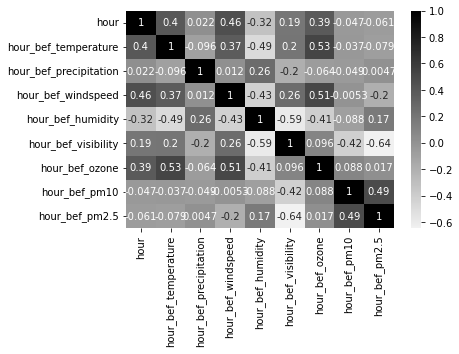

In [15]:
cmap = sns.light_palette(color="black", as_cmap=True)
# as_cmap=True : 반환되는 값이 컬러맵 객체가 됨
sns.heatmap(x.corr(), annot=True, cmap=cmap)
# annot=True : 숫자 표시
plt.show()

In [55]:
# correlation between visibility & pm2.5 = -0.64
# visibility와 pm2.5 비교
x.corrwith(other=y)

hour                      0.622092
hour_bef_temperature      0.610744
hour_bef_precipitation   -0.159124
hour_bef_windspeed        0.458143
hour_bef_humidity        -0.461788
hour_bef_visibility       0.306605
hour_bef_ozone            0.466119
hour_bef_pm10            -0.135949
hour_bef_pm2.5           -0.134293
dtype: float64

In [56]:
# corr visibility = 0.306605 > corr pm2.5 = -0.134293
# drop hour_bef_pm2.5
x2 = x.drop(['hour_bef_pm2.5'], axis=1)

In [57]:
x2

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10
0,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0
1,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0
2,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0
3,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0
4,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0
...,...,...,...,...,...,...,...,...
1337,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0
1338,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0
1339,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0
1340,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0


#### 2 VIF를 통해 다중공선성 위험이 제일 큰 변수 한개를 제거
* 이때 X가 아닌 heatmap을 통해 변수 한개를 제거한 X2를 통해 VIF 계산
* 변수 제거 후에는 X3로 새로 지정


In [58]:
vif = pd.DataFrame()
vif["features"] = x2.columns
vif["VIF factor"] = [variance_inflation_factor(x2.values, i) for i in range(x2.shape[1])]
vif

,features,VIF factor
0,hour,5.777988
1,hour_bef_temperature,15.104114
2,hour_bef_precipitation,1.145521
3,hour_bef_windspeed,6.950266
4,hour_bef_humidity,4.318150
5,hour_bef_visibility,6.589934
6,hour_bef_ozone,8.710461
7,hour_bef_pm10,4.022496


In [59]:
x3 = x2.drop(['hour_bef_temperature'], axis=1)
x3

,hour,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10
0,20,1.0,1.5,89.0,576.0,0.027,76.0
1,13,0.0,1.4,48.0,916.0,0.042,73.0
2,6,0.0,0.7,79.0,1382.0,0.033,32.0
3,23,0.0,2.7,54.0,946.0,0.040,75.0
4,18,0.0,4.8,7.0,2000.0,0.057,27.0
...,...,...,...,...,...,...,...
1337,4,0.0,1.6,53.0,2000.0,0.031,37.0
1338,3,0.0,3.8,45.0,2000.0,0.039,34.0
1339,5,0.0,1.9,54.0,2000.0,0.009,30.0
1340,21,0.0,3.7,37.0,1395.0,0.082,71.0


#### 3 heatmap, VIF를 통해 다중공선성이 제거된 데이터로 statsmodel을 통해 summary 출력

In [60]:
vifx3 = sm.add_constant(x3, has_constant='add')
lin_model_1 = sm.OLS(y, vifx3)
lin_model_1 = lin_model_1.fit()

In [61]:
lin_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     213.3
Date:                Mon, 10 Oct 2022   Prob (F-statistic):          2.05e-212
Time:                        00:21:34   Log-Likelihood:                -7330.2
No. Observations:                1342   AIC:                         1.468e+04
Df Residuals:                    1334   BIC:                         1.472e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     90.3967     15.571      5.805      0.000      59.849     120.944
hour                       5.5269      0.269     20.510      0.000       4.998       6.056
hour_bef_precipitation   -57.2426      9.678     -5.915      0.000     -76.229     -38.257
hour_bef_windspeed         4.8049      1.451      3.312      0.001       1.959       7.651
hour_bef_humidity         -0.9260      0.124     -7.483      0.000      -1.169      -0.683
hour_bef_visibility       -0.0069      0.004     -1.616      0.106      -0.015       0.001
hour_bef_ozone           742.2018    100.840      7.360      0.000     544.380     940.024
hour_bef_pm10             -0.4678      0.063     -7.441      0.000      -0.591      -0.344
==============================================================================
Omnibus:                      148.683   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.606
Skew:                           0.817   Prob(JB):                     1.52e-47
Kurtosis:                       4.088   Cond. No.                     9.91e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 1-3) K-Fold 통한 성능평가

#### 1. 학습, 테스트 데이터 8:2비율로 분할 
* random state=0 으로 지정

In [62]:
train_x, test_x, train_y, test_y = train_test_split(x3, y, train_size=0.8, test_size=0.2, random_state=1)

#### 2.  Ridge, Lasso 모델을 하이퍼라미터 값을 변경해가면서 10-Fold를 통해 학습데이터 평가 
* 하이퍼라미터 후보 : alpha = [0.001, 0.01, 0.1, 1, 10]
* 평가지표 : R2 score

In [63]:
alpha_list = [0.001, 0.01, 0.1, 1, 10]

ridge_r2_list_train=[]
ridge_r2_list_test=[]

lasso_r2_list_train=[]
lasso_r2_list_test=[]

for alpha in alpha_list:
    lasso = Lasso(alpha=alpha)
    ridge = Ridge(alpha=alpha)
    
    lasso_r2_list_train.append(np.mean(cross_val_score(lasso, train_x, train_y, scoring='r2',cv=KFold(n_splits=10, shuffle=True, random_state=1))))
    ridge_r2_list_train.append(np.mean(cross_val_score(ridge, train_x, train_y, scoring='r2',cv=KFold(n_splits=10, shuffle=True, random_state=1))))


[0.5210119743807003, 0.5210891497730922, 0.5202813289188113, 0.5117126509953509, 0.5059275718641395]
[0.5210088742095893, 0.5210337484815867, 0.5157893630999322, 0.49999854210882394, 0.4837702752003244]


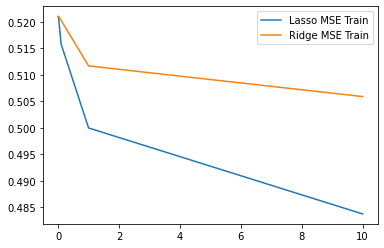

In [66]:
print(ridge_r2_list_train)
print(lasso_r2_list_train)

plt.plot(alpha_list, lasso_r2_list_train, label='Lasso MSE Train')
plt.plot(alpha_list, ridge_r2_list_train, label='Ridge MSE Train')
plt.legend()

#### 3. 학습데이터로 평가했을 때 가장 좋은 성능을 보인 하이퍼 파라미터값을 기준으로 Ridge, Lasso 모델을 만들어 테스트 데이터로 평가
* 평가지표 : R2, MSE

In [67]:
best_lasso = Lasso(alpha=0.01)
best_ridge = Ridge(alpha=0.01)

best_lasso.fit(train_x, train_y)
best_ridge.fit(train_x, train_y)

lasso_mse_test = mean_squared_error(test_y, best_lasso.predict(test_x))
ridge_mse_test = mean_squared_error(test_y, best_ridge.predict(test_x))
lasso_r2_test = r2_score(test_y, best_lasso.predict(test_x))
ridge_r2_test = r2_score(test_y, best_ridge.predict(test_x))

print(f"mse of lasso = {lasso_mse_test}")
print(f"mse of ridge = {ridge_mse_test}")
print(f"r2 of lasso = {lasso_r2_test}")
print(f"r2 of ridge = {ridge_r2_test}")

mse of lasso = 3389.730271309179
mse of ridge = 3387.461356752851
r2 of lasso = 0.47085661277641766
r2 of ridge = 0.4712107946839924


# 2. Classification

## 데이터 불러오기

In [84]:
wine = pd.read_csv("./data/classification.csv")

## 2-1) 데이터 전처리

#### 1. type값의 white, red를 숫자로 변경. 이때 white은 0 red는 1로 변경


In [85]:
wine['type']=np.where(wine['type']=='white', 0, wine['type'])
wine['type']=np.where(wine['type']=='red', 1, wine['type'])

#### 2 type을 y, 나머지 변수를 X값으로 분할


In [86]:
wx = wine.drop(['type'], axis=1, inplace=False)
wy = wine['type']

#### 3 X, y 를 8: 2로 데이터 분할(이때 y값 데이터가 불균형이 있다면 균일한 비율로 분할 진행)
* random state = 1 로 고정

In [87]:
train_wx, test_wx, train_wy, test_wy = train_test_split(wx, wy, train_size=0.8, random_state=1, stratify=wy)

#### 4. X 데이터 Standard Scale 진행


In [88]:
scale = StandardScaler()
scale.fit(train_wx)

train_wx = pd.DataFrame(scale.transform(train_wx), columns=train_wx.columns)
test_wx = pd.DataFrame(scale.transform(test_wx), columns=test_wx.columns)

#### 5. train_X와 train_y의 통계량 출력(describe 함수 사용)

In [89]:
train_wx.describe()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4.397000e+03,4.397000e+03,4.397000e+03,4.397000e+03,4.397000e+03,4.397000e+03,4.397000e+03,4.397000e+03,4.397000e+03,4.397000e+03,4.397000e+03,4.397000e+03
mean,-2.565355e-16,2.053874e-16,4.565120e-17,-1.730983e-16,1.457404e-16,9.065853e-17,-5.650851e-17,-2.888549e-17,1.308361e-14,8.957028e-16,-4.131080e-16,-8.604039e-16
std,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00
min,-3.222467e+00,-2.598173e+00,-1.590381e+00,-2.241634e+00,-1.026032e+00,-1.378994e+00,-1.655318e+00,-1.949450e+00,-2.546053e+00,-2.980231e+00,-2.084266e+00,-1.756277e+00
25%,-9.372983e-01,-6.390549e-01,-6.574173e-01,-4.871902e-01,-7.686988e-01,-5.270247e-01,-7.530840e-01,-6.657428e-01,-8.024685e-01,-6.798087e-01,-6.763825e-01,-8.397119e-01
50%,2.052857e-01,-1.688665e-01,-2.842318e-01,-6.612380e-02,-5.328097e-01,-2.626204e-01,-7.640875e-02,4.742779e-02,5.070277e-02,-5.807297e-02,-1.400458e-01,-1.731191e-01
75%,2.052857e-01,3.796867e-01,3.999417e-01,4.952981e-01,5.823022e-01,2.368100e-01,6.002665e-01,7.071106e-01,7.684500e-01,6.258363e-01,4.633329e-01,7.017840e-01
max,3.633038e+00,6.805595e+00,7.739257e+00,6.390228e+00,5.621750e+00,1.198811e+01,1.458489e+01,5.788451e+00,5.298383e+00,4.915813e+00,9.715140e+00,3.659790e+00


In [90]:
train_wy.describe()

count     4397
unique       2
top          0
freq      3327
Name: type, dtype: int64

## 2-2) 모델 학습 및 평가

#### 1. Logistic Regression과 KNN모델을 하이퍼 파라미터 값을 변경해가면서 10-Fold를 통해 학습데이터 평가 
* Logistic Regression 하이퍼파라미터 후보 : C =0.01,0.1,1,10
* KNN 하이퍼파라미터 후보 : n_neighbors = 1,3,5,7
* 평가지표 : Recall


In [79]:
LR_hpar = [0.01, 0.1, 1, 10]
KNN_hpar = [1, 3, 5, 7]

LR_recall_list_train = []
KNN_recall_list_train = []

LR_recall_list_test = []
KNN_recall_list_test = []

for c in LR_hpar:
    LR = LogisticRegression(C=c)
    LR_recall_list_train.append(np.mean(cross_val_score(LR, train_wx, train_wy.astype('int'), scoring='recall', cv=KFold(n_splits=10, shuffle=True, random_state=1))))
    
for nn in KNN_hpar:
    KNN = KNeighborsClassifier(n_neighbors = nn)
    KNN_recall_list_train.append(np.mean(cross_val_score(KNN, train_wx, train_wy.astype('int'), scoring='recall', cv=KFold(n_splits=10, shuffle=True, random_state=1))))

print(f"Logistic Regression\t: {LR_recall_list_train}")
print(f"KNN \t\t\t: {KNN_recall_list_train}")

Logistic Regression	: [0.9760251472756977, 0.98623991126445, 0.9899599600282262, 0.9900750042760137]
KNN 			: [0.987077463872559, 0.9871404248367615, 0.9871404248367612, 0.9891475147497488]


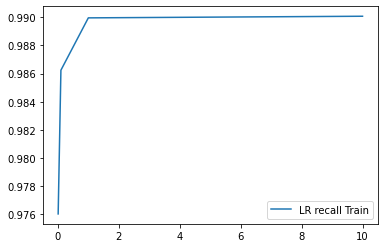

In [80]:
plt.plot(LR_hpar, LR_recall_list_train, label='LR recall Train')
plt.legend()

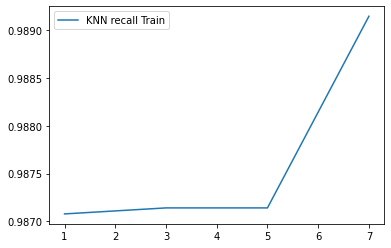

In [81]:
plt.plot(KNN_hpar, KNN_recall_list_train, label='KNN recall Train')
plt.legend()

#### 2. 학습데이터로 평가했을 때 가장 좋은 성능을 보인 하이퍼 파라미터값을 기준으로 Logistic Regression, KNN모델을 만들어 테스트 데이터로 평가
* 평가지표 Recall, Precision, F1-score

In [83]:
# C=10
# n_neighbors = 7 
best_LR = LogisticRegression(C=10)
best_KNN = KNeighborsClassifier(n_neighbors = 7)

best_LR.fit(train_wx, train_wy.astype('int'))
best_KNN.fit(train_wx, train_wy.astype('int'))

print(f"recall for LR = {recall_score(test_wy.astype('int'), best_LR.predict(test_wx))}")
print(f"recall for KNN = {recall_score(test_wy.astype('int'), best_KNN.predict(test_wx))}")
print(f"precision for LR = {precision_score(test_wy.astype('int'), best_LR.predict(test_wx))}")
print(f"precision for KNN = {precision_score(test_wy.astype('int'), best_KNN.predict(test_wx))}")
print(f"f1-score for LR = {f1_score(test_wy.astype('int'), best_LR.predict(test_wx))}")
print(f"f1-score for KNN = {f1_score(test_wy.astype('int'), best_KNN.predict(test_wx))}")

recall for LR = 0.9850746268656716
recall for KNN = 0.9850746268656716
precision for LR = 0.9887640449438202
precision for KNN = 0.9850746268656716
f1-score for LR = 0.9869158878504672
f1-score for KNN = 0.9850746268656716
